In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#Classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#Measures
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import cluster
from sklearn.cluster import KMeans

#Plots
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import matplotlib
font = {'family' : 'Times New Roman',
        'size'   : 14}

matplotlib.rc('font', **font)

# Measures

In [2]:
#-------Label Purity--------

def label_purity(X, y):
    n_clusters = 2#y.nunique()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    y_pred = kmeans.fit_predict(X)
    contingency_matrix = cluster.contingency_matrix(y, y_pred)
    return ((np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)) - 0.5 ) * 2

In [3]:
def edit_label_purity(y, frac):
    y_new = y.copy()
    for idx in y.sample(frac=frac, random_state=42).index:
        y_new.iloc[idx] = 1 - y.iloc[idx]
    return y_new

In [4]:
measures_steps = {
    'Label Purity': [0, 0.2, 0.3, 0.35, 0.4]
}
n_steps = len(list(measures_steps.values())[0])
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}
classifier_names = list(classifiers.keys())

metrics = {
    'Accuracy': np.zeros((len(classifiers), n_steps)),
    'Precision': np.zeros((len(classifiers), n_steps)),
    'Recall': np.zeros((len(classifiers), n_steps)),
    'F1 Score': np.zeros((len(classifiers), n_steps))
}

# Dataset

In [5]:
heart_attack = pd.read_csv('dataset/heart_attack.csv')
heart_attack = heart_attack.sample(frac=1, random_state=42).reset_index(drop=True)
X = heart_attack.drop('output', axis=1)
y = heart_attack['output']
dataset_name = 'heart_attack'

In [7]:
stroke = pd.read_csv('dataset/stroke.csv')
stroke.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
stroke = pd.read_csv('dataset/stroke.csv')
X = stroke.drop(['stroke', 'id'], axis=1)
y = stroke['stroke']
X.fillna(method='ffill',inplace=True)


enc = LabelEncoder()
for i in X.columns:
    if X[i].dtype == "object":
        X[i]=enc.fit_transform(X[i])


dataset_name = 'stroke'

In [11]:
marketing_campaign = pd.read_csv('dataset/marketing_campaign.csv',sep=';').sample(frac=1,random_state=42).reset_index(drop=True)
marketing_campaign = marketing_campaign.dropna()
marketing_campaign= marketing_campaign.reset_index(drop=True)
X = marketing_campaign.drop(['Response', 'ID', 'Dt_Customer'], axis=1)
y = marketing_campaign['Response']



enc = LabelEncoder()
for i in X.columns:
    if X[i].dtype == "object":
        X[i]=enc.fit_transform(X[i])

dataset_name = 'marketing_campaign'

In [14]:
heart_failure = pd.read_csv('dataset/heart_failure.csv')
X = heart_failure.drop(['HeartDisease'], axis=1)
y = heart_failure['HeartDisease']


enc = LabelEncoder()
for i in X.columns:
    if X[i].dtype == "object":
        X[i]=enc.fit_transform(X[i])


dataset_name = 'heart_failure'

In [17]:
airline_passenger = pd.read_csv('dataset/airline_passenger.csv')
airline_passenger.dropna(inplace=True)
airline_passenger = airline_passenger.reset_index(drop=True)

X = airline_passenger.drop(['satisfaction','Unnamed: 0','id'], axis=1)
y = airline_passenger['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1})


enc = LabelEncoder()
for i in X.columns:
    if X[i].dtype == "object":
        X[i]=enc.fit_transform(X[i])


dataset_name = 'airline_passenger'

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

measure_value = []
for k, measure_steps in enumerate(measures_steps):

    for i, step in enumerate(measures_steps.get(measure_steps)):

        if(i==0):
            X_train_new, y_train_new = X_train, y_train
        else:
            y_train_new = edit_label_purity(y_train, step)

        measure_value.append(label_purity(X_train_new, y_train_new))

        for j, (classifier_name, classifier) in enumerate(classifiers.items()):
            # Standardize the features (optional but often recommended)
            scaler = StandardScaler()
            train_X_scaled = scaler.fit_transform(X_train_new)
            test_X_scaled = scaler.transform(X_test)

            # Train the classifier
            classifier.fit(train_X_scaled, y_train_new)

            # Make predictions on the fixed test set
            predictions = classifier.predict(test_X_scaled)
            # Calculate metrics and store in the metrics dictionary
            metrics['Accuracy'][j, i] = accuracy_score(y_test, predictions)
            metrics['Precision'][j, i] = precision_score(y_test, predictions, average='weighted')
            metrics['Recall'][j, i] = recall_score(y_test, predictions, average='weighted')
            metrics['F1 Score'][j, i] = f1_score(y_test, predictions, average='weighted')

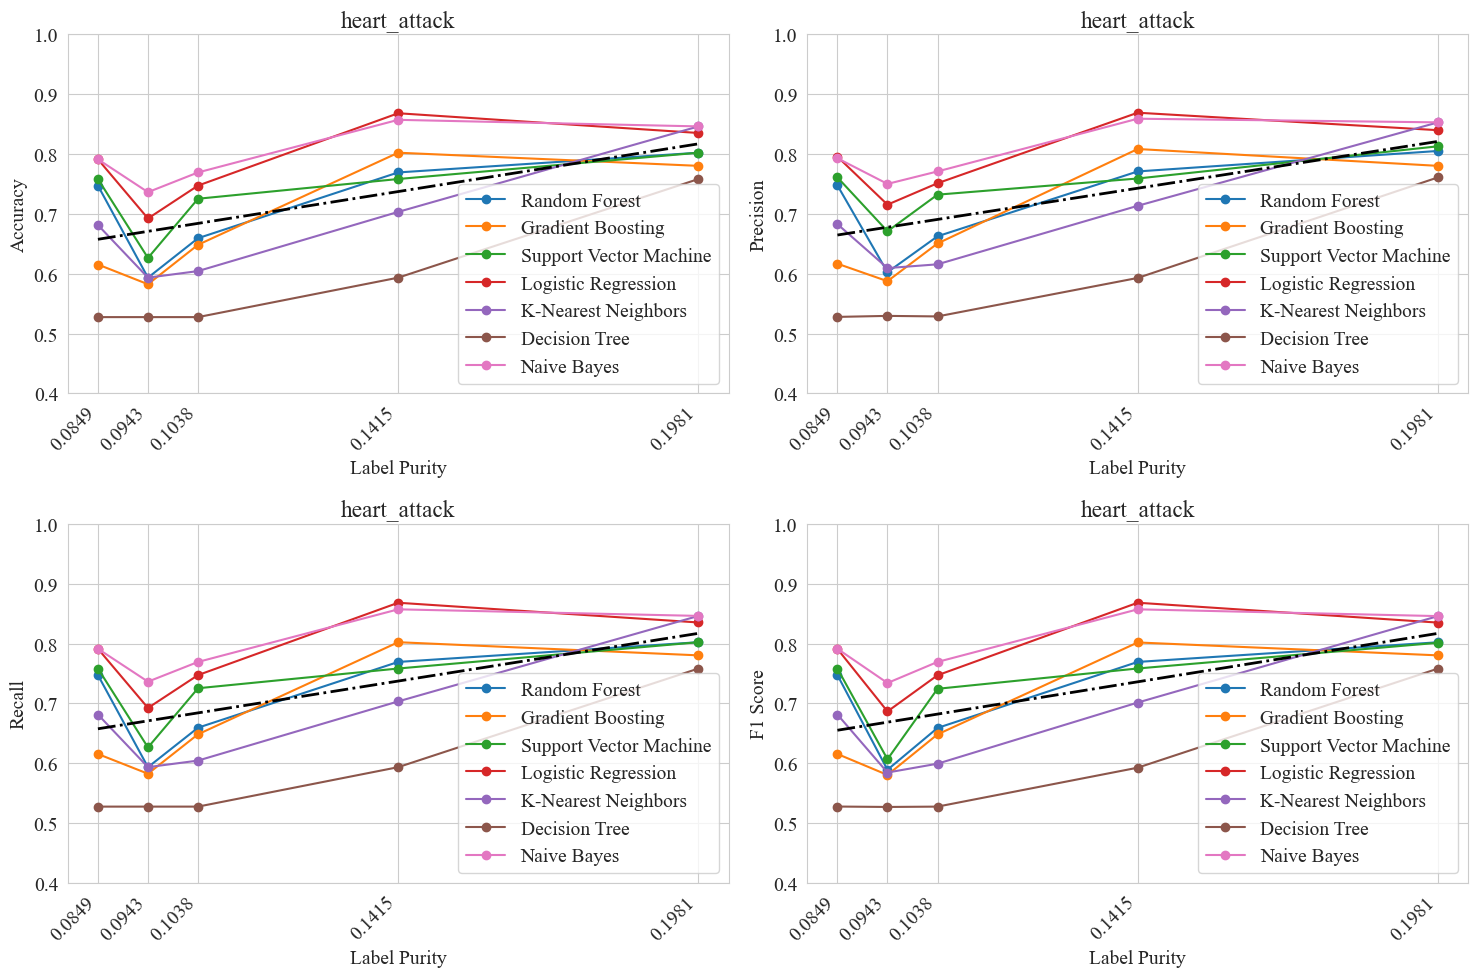

In [7]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/label_purity_{dataset_name}.svg', format='svg')
plt.show()

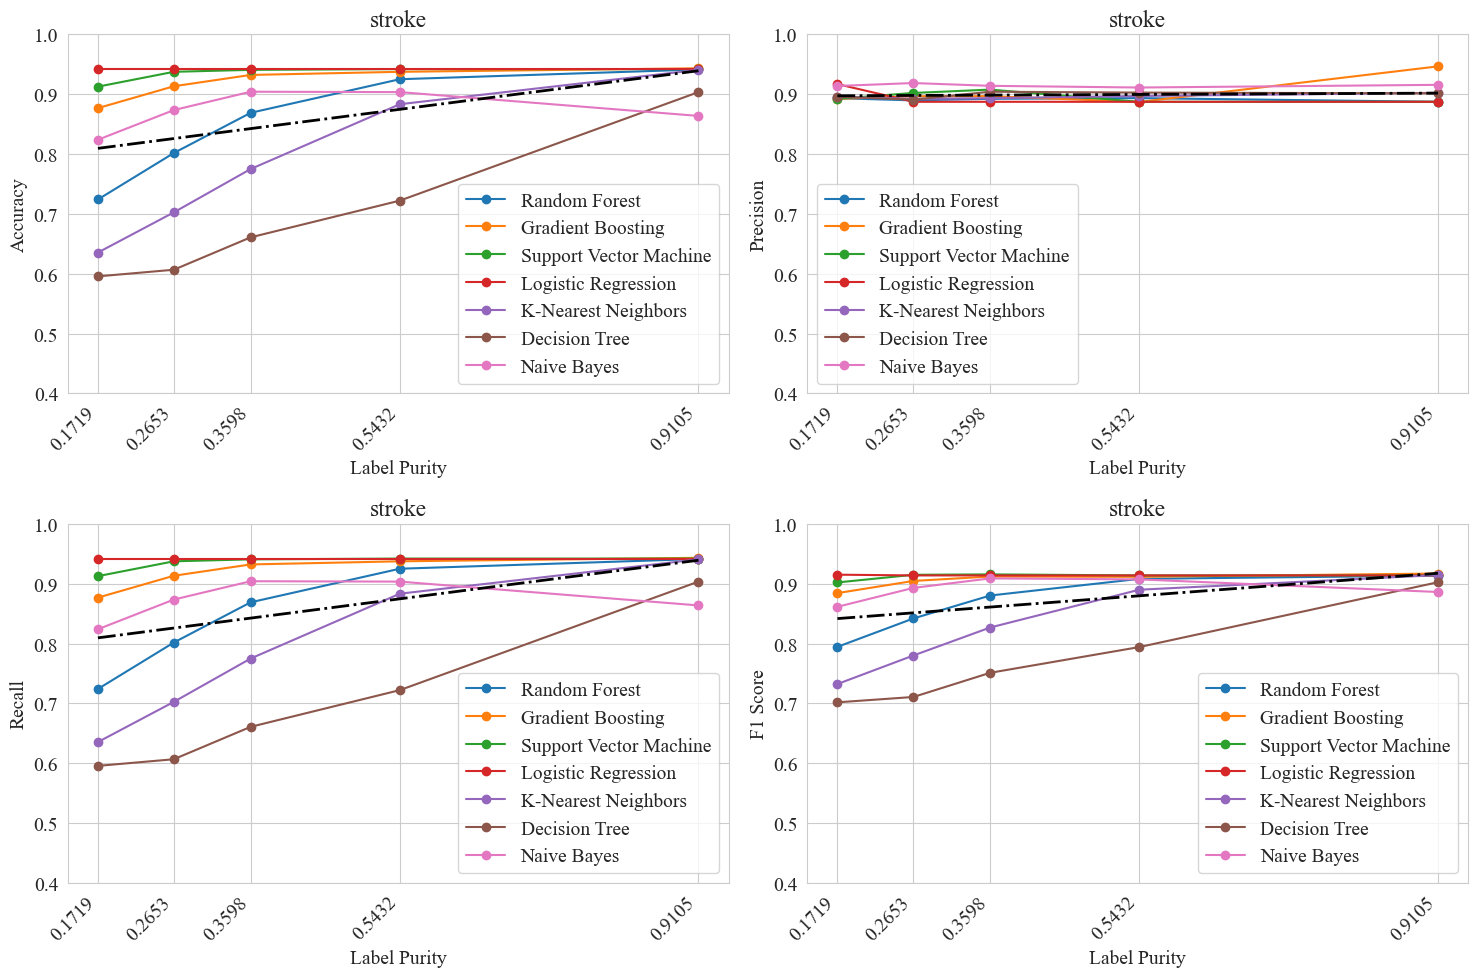

In [10]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/label_purity_{dataset_name}.svg', format='svg')
plt.show()

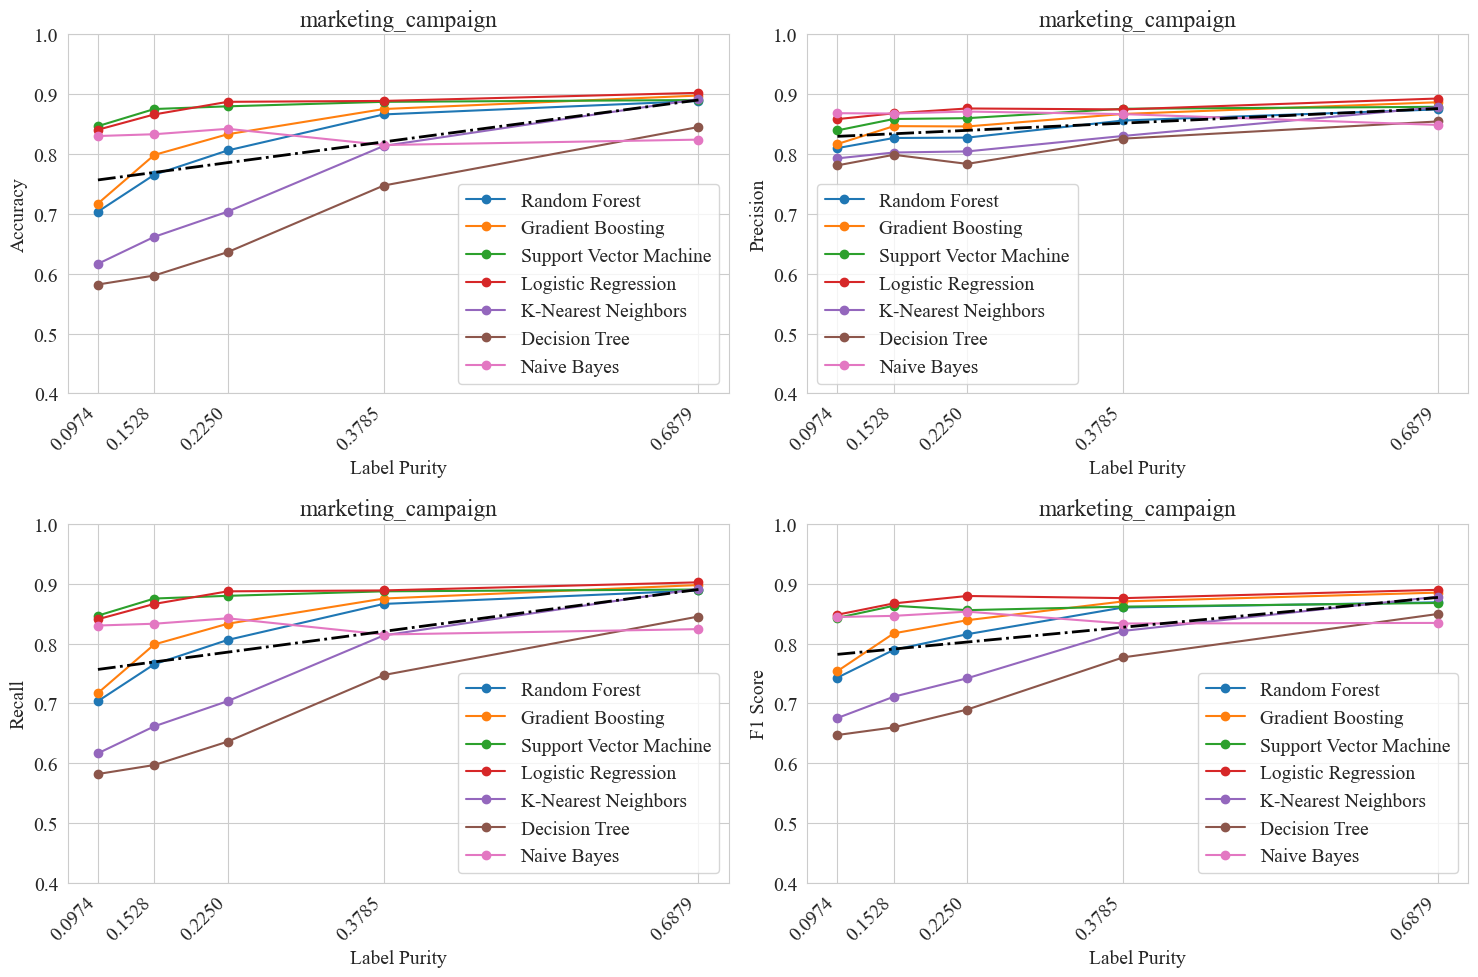

In [13]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/label_purity_{dataset_name}.svg', format='svg')
plt.show()

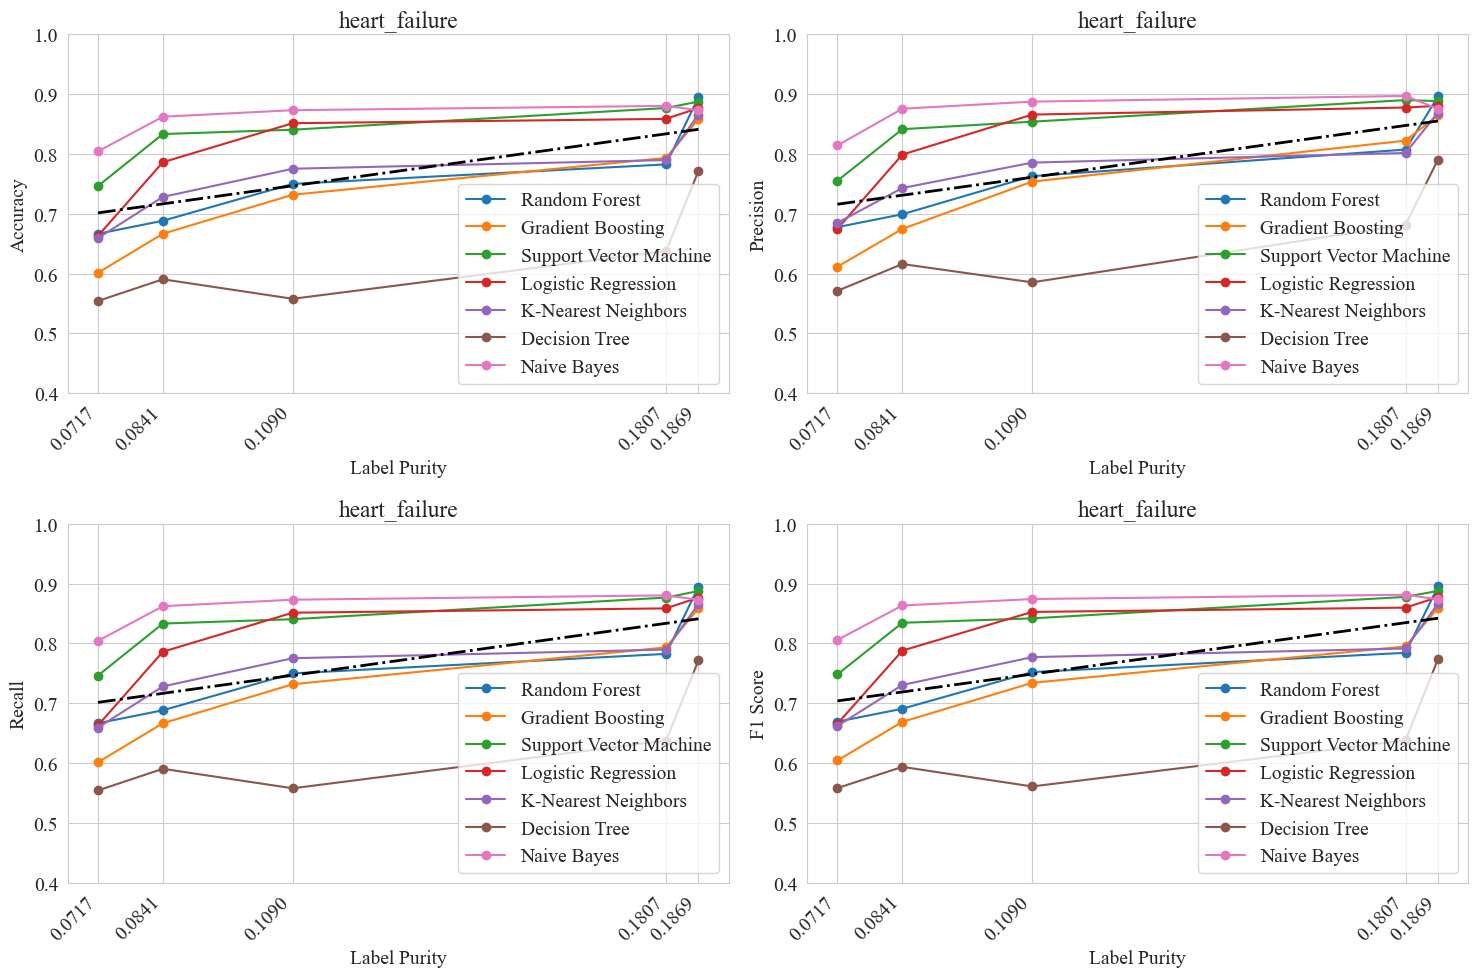

In [16]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/label_purity_{dataset_name}.svg', format='svg')
plt.show()

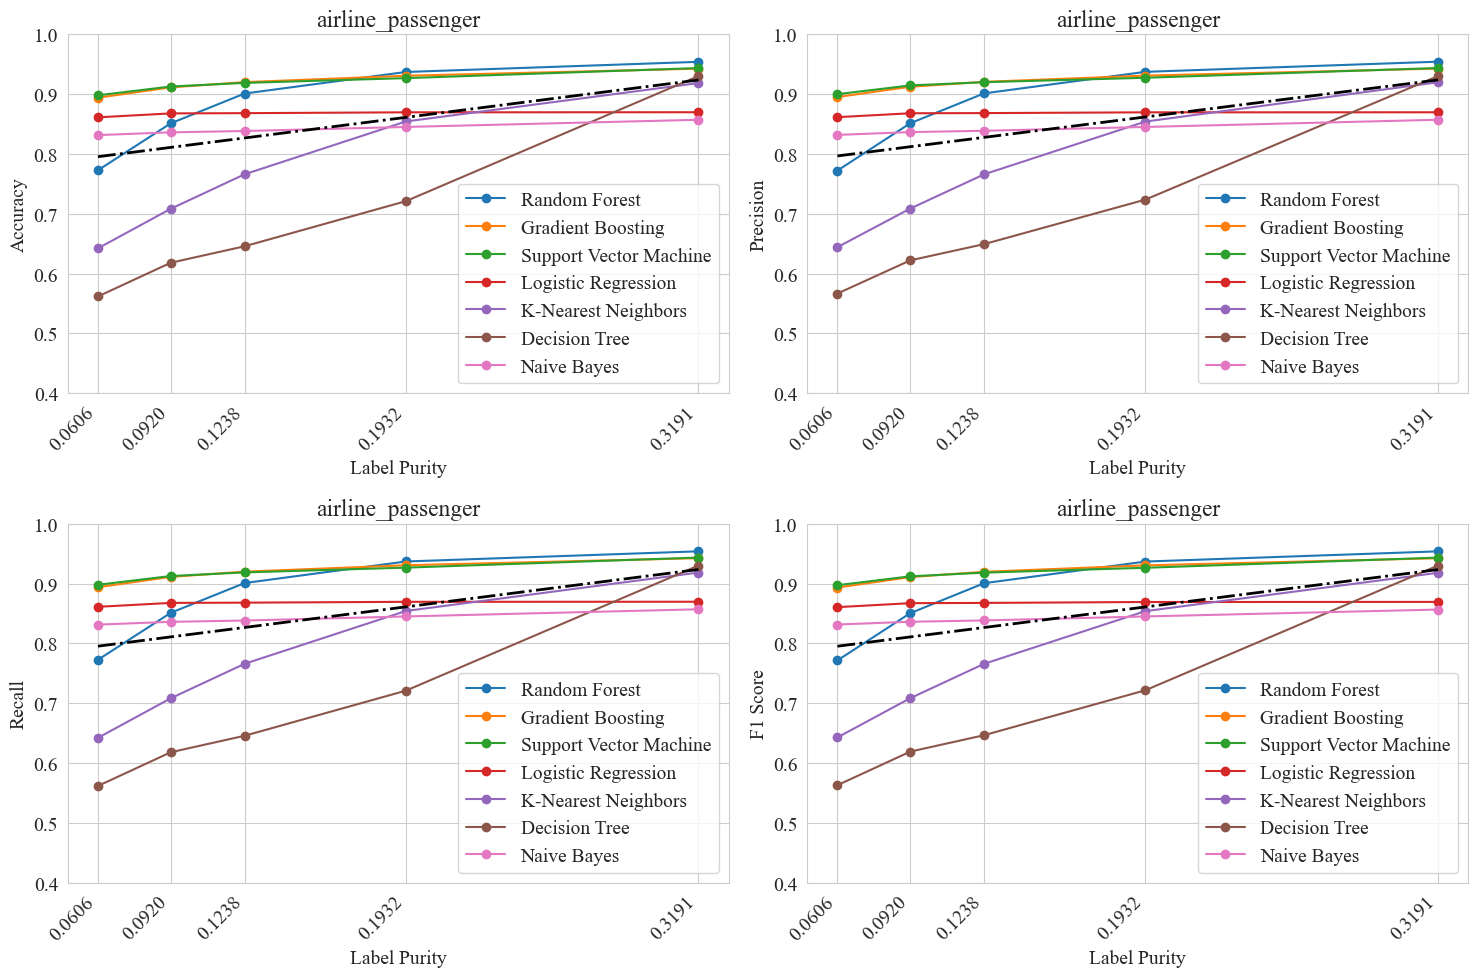

In [19]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/label_purity_{dataset_name}.svg', format='svg')
plt.show()

In [20]:
dataset_name = 'synthetic_dataset'

measure_value = []
for k, measure_steps in enumerate(measures_steps):

    for i, step in enumerate(measures_steps.get(measure_steps)):

        X, y = make_classification(
                    n_samples=1000,  # Total number of samples
                    n_features=20,    # Number of features
                    n_informative=3, # Number of informative features (set to n_features for simplicity)
                    n_redundant=0,   # Number of redundant features
                    n_clusters_per_class=2, # Number of clusters per class
                    flip_y = step,
                    random_state=42
                )

        X_train_new, X_test, y_train_new, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        measure_value.append(label_purity(X_train_new, y_train_new))

        for j, (classifier_name, classifier) in enumerate(classifiers.items()):
            # Standardize the features (optional but often recommended)
            scaler = StandardScaler()
            train_X_scaled = scaler.fit_transform(X_train_new)
            test_X_scaled = scaler.transform(X_test)

            # Train the classifier
            classifier.fit(train_X_scaled, y_train_new)

            # Make predictions on the fixed test set
            predictions = classifier.predict(test_X_scaled)
            # Calculate metrics and store in the metrics dictionary
            metrics['Accuracy'][j, i] = accuracy_score(y_test, predictions)
            metrics['Precision'][j, i] = precision_score(y_test, predictions, average='weighted')
            metrics['Recall'][j, i] = recall_score(y_test, predictions, average='weighted')
            metrics['F1 Score'][j, i] = f1_score(y_test, predictions, average='weighted')

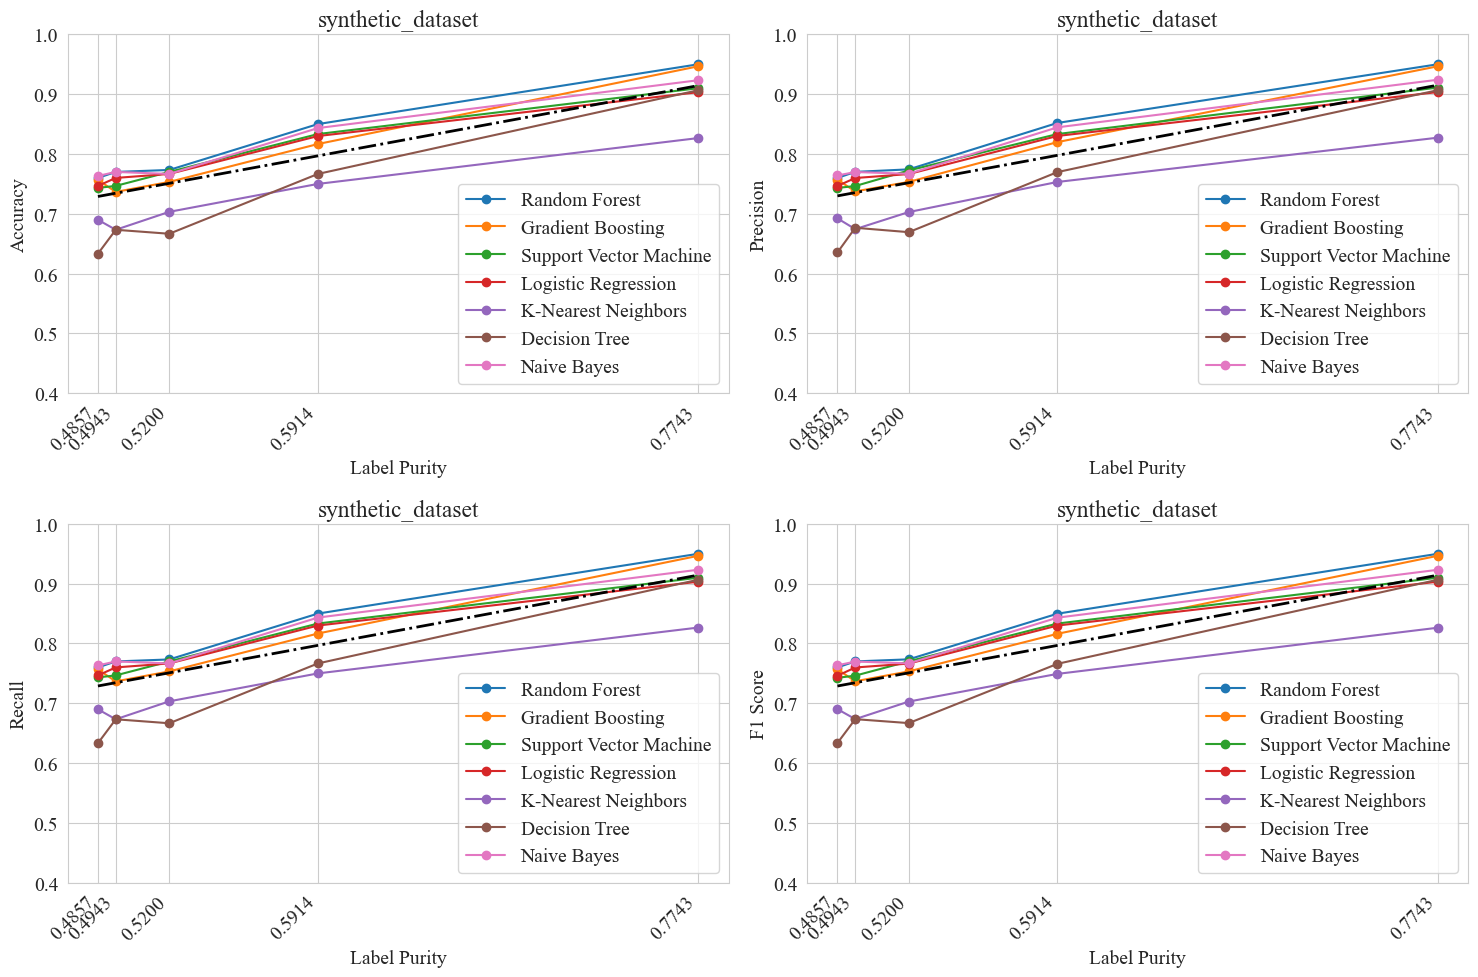

In [21]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/label_purity_{dataset_name}.svg', format='svg')
plt.show()